In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# reading data
df=pd.read_excel("Online_Retail.xlsx")
# showing the first five rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Understanding the data set:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df.duplicated().sum()

5268

### Visualization in terms of Graphs:

#### Scatter plot of Quantity vs Unit Price:

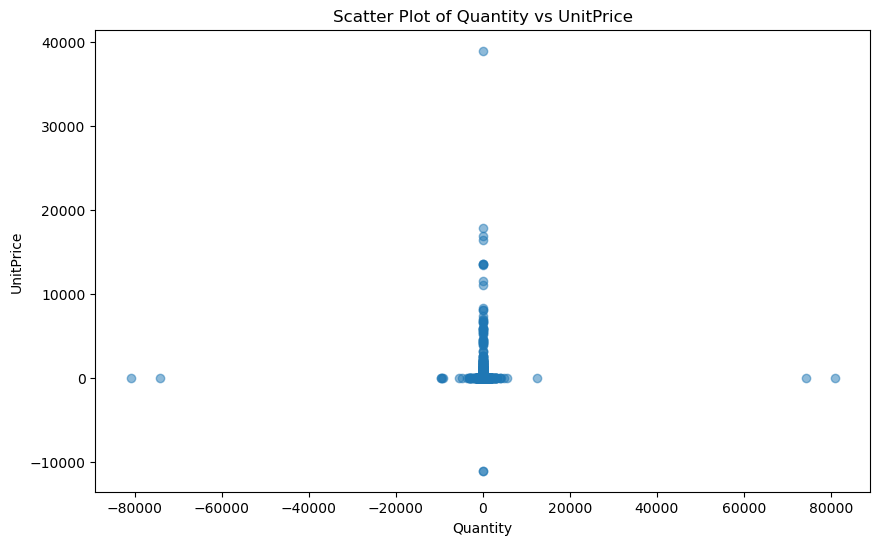

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Quantity'], df['UnitPrice'], alpha=0.5)
plt.title('Scatter Plot of Quantity vs UnitPrice')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.show()

#### Histogram for Quantity:

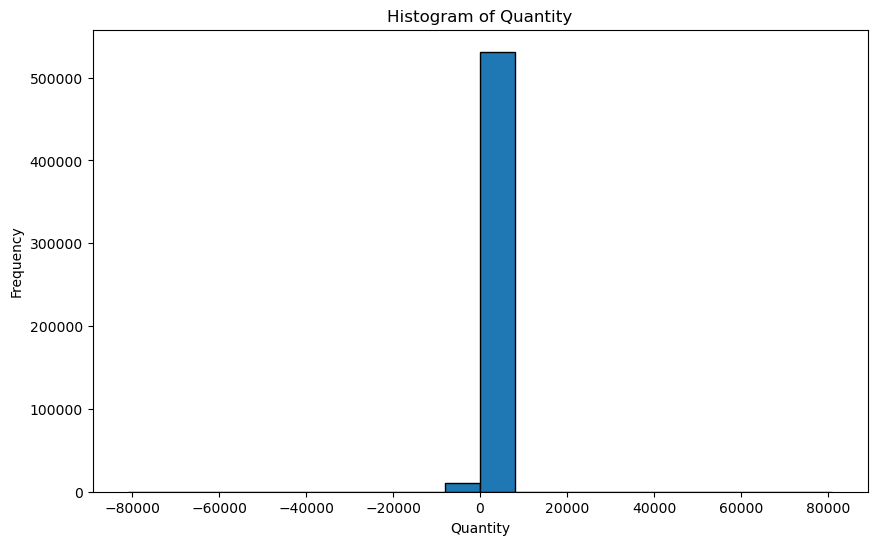

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df['Quantity'], bins=20, edgecolor='black')
plt.title('Histogram of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

#### Bar Plot for StockCode Counts:

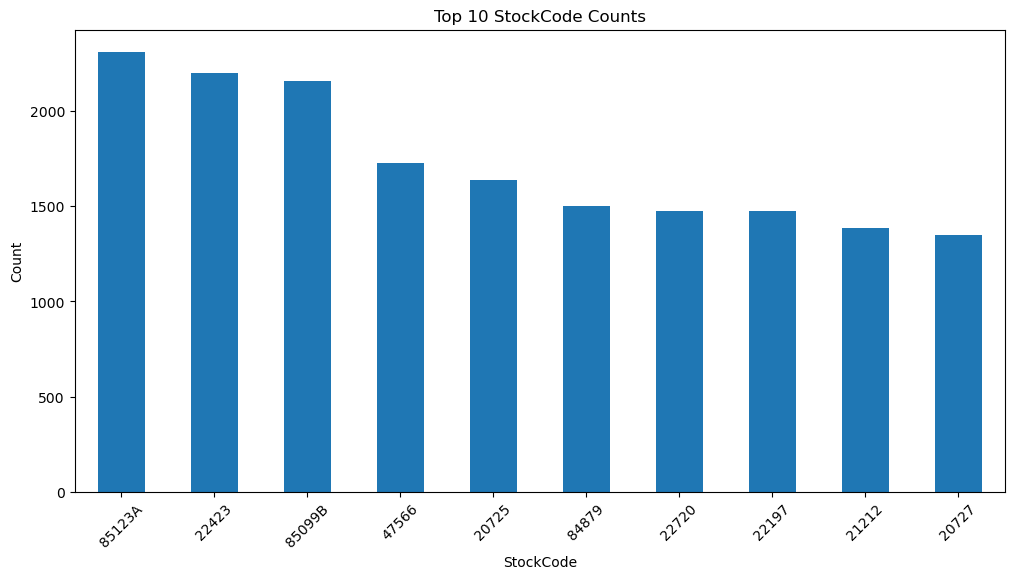

In [11]:
stockcode_counts = df['StockCode'].value_counts().head(10)  # Display top 10
plt.figure(figsize=(12, 6))
stockcode_counts.plot(kind='bar')
plt.title('Top 10 StockCode Counts')
plt.xlabel('StockCode')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Line Plot for InvoiceDate Trends:

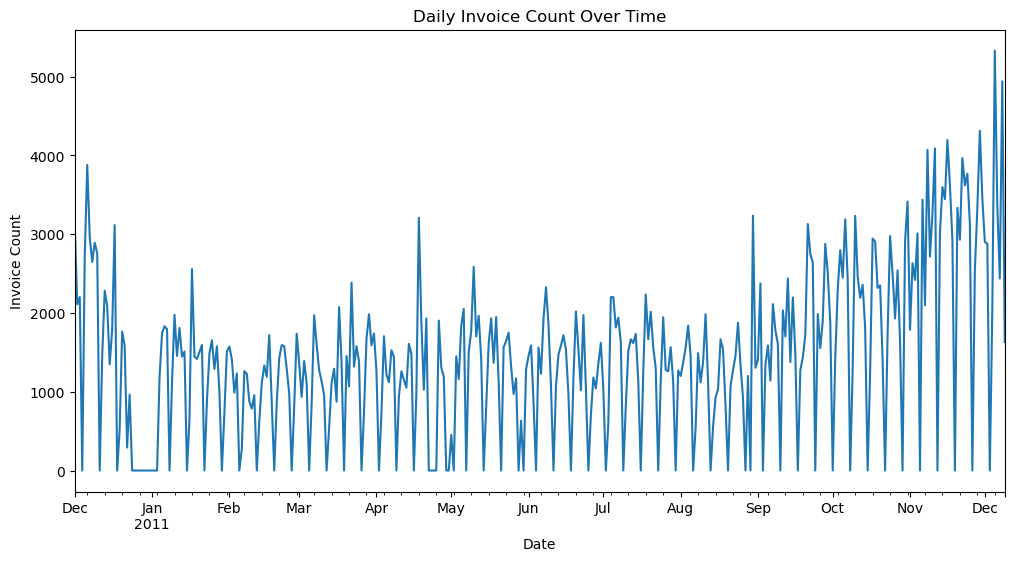

In [12]:
df_time_series = df.set_index('InvoiceDate')
df_time_series.resample('D').size().plot(figsize=(12, 6))
plt.title('Daily Invoice Count Over Time')
plt.xlabel('Date')
plt.ylabel('Invoice Count')
plt.show()

#### Pie Chart for Country Distribution:

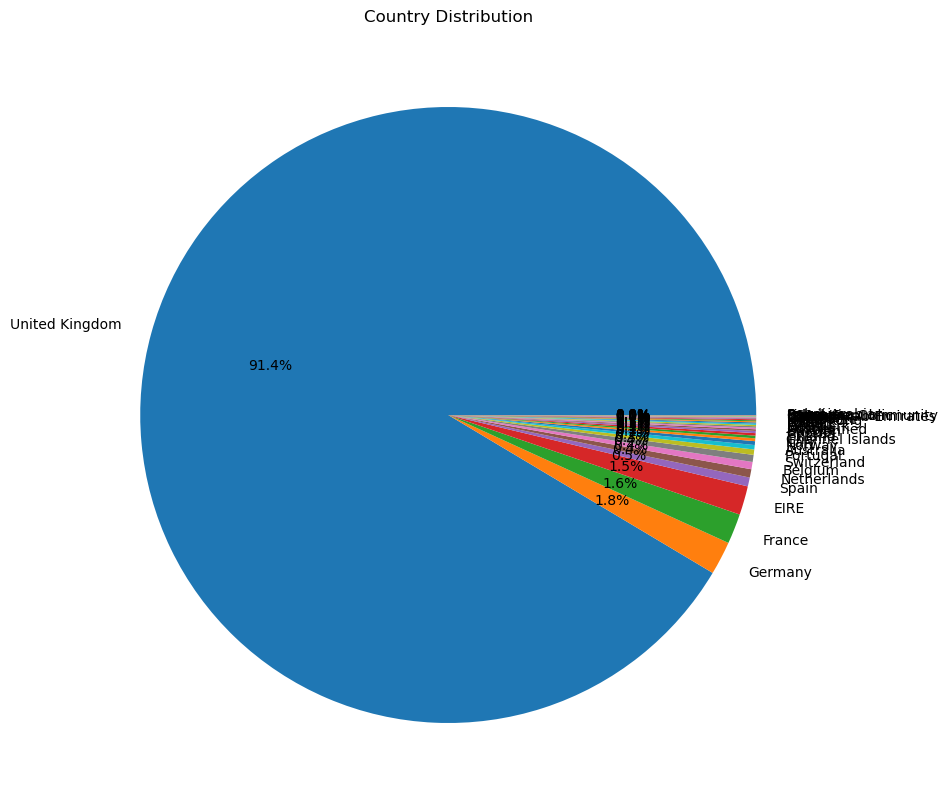

In [13]:
country_distribution = df['Country'].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(country_distribution, labels=country_distribution.index, autopct='%1.1f%%')
plt.title('Country Distribution')
plt.show()

#### Box Plot for Quantity by Country:

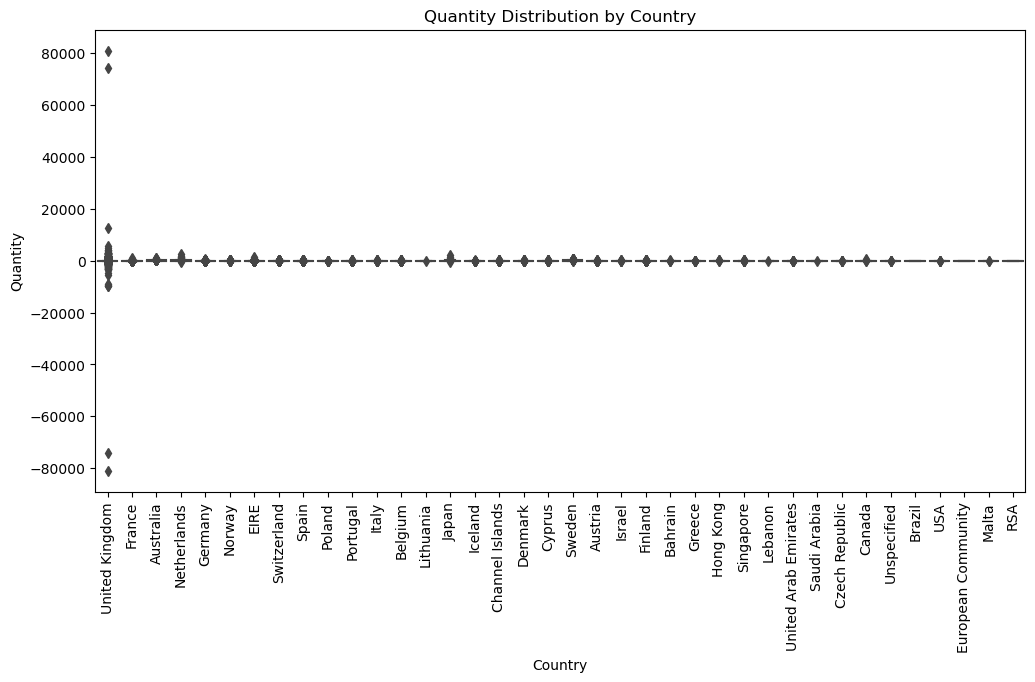

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Country', y='Quantity', data=df)
plt.title('Quantity Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Quantity')
plt.xticks(rotation=90)
plt.show()

#### Line Plot for Quantity Trends over Time:

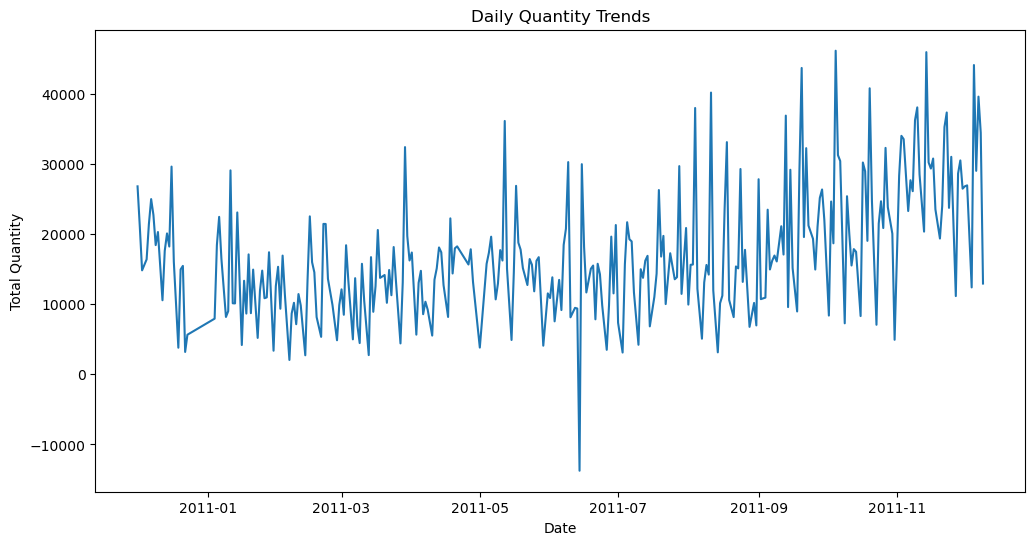

In [15]:
df['Date'] = df['InvoiceDate'].dt.date
daily_quantity = df.groupby('Date')['Quantity'].sum()
plt.figure(figsize=(12, 6))
daily_quantity.plot()
plt.title('Daily Quantity Trends')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.show()

### RFM:

In [16]:
from datetime import datetime, timedelta

#### Data Preprocessing:

In [17]:
# Ensure the date column is a datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate the monetary value for each transaction
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

#### Calculate Recency, Frequency, and Monetary Values:

In [18]:
# Decide on a snapshot date, which is one day after the last transaction in the dataset
snapshot_date = max(df['InvoiceDate']) + timedelta(days=1)

# Aggregate data on a per-customer basis
rfm_data = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalSum': 'sum'  # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
})

#### Assign RFM Scores:

In [20]:
rfm_data['R'] = pd.qcut(rfm_data['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm_data['F'] = pd.qcut(rfm_data['Frequency'], 5, labels=False, duplicates='drop') + 1
rfm_data['M'] = pd.qcut(rfm_data['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Combine the scores into a single string
rfm_data['RFM_Segment'] = rfm_data['R'].astype(str) + rfm_data['F'].astype(str) + rfm_data['M'].astype(str)
rfm_data['RFM_Score'] = rfm_data[['R', 'F', 'M']].sum(axis=1)


#### Define RFM Segments:

In [21]:
def segment_customers(score):
    if score >= 13:
        return "Top Customers"
    elif score >= 10:
        return "Loyal Customers"
    elif score >= 7:
        return "Promising"
    else:
        return "Require Attention"

rfm_data['Customer_Segment'] = rfm_data['RFM_Score'].apply(segment_customers)


In [22]:
rfm_data

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Customer_Segment
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3,Require Attention
12347.0,2,7,4310.00,5,3,5,535,13,Top Customers
12348.0,75,4,1797.24,2,2,4,224,8,Promising
12349.0,19,1,1757.55,4,1,4,414,9,Promising
12350.0,310,1,334.40,1,1,2,112,4,Require Attention
...,...,...,...,...,...,...,...,...,...
18280.0,278,1,180.60,1,1,1,111,3,Require Attention
18281.0,181,1,80.82,1,1,1,111,3,Require Attention
18282.0,8,3,176.60,5,2,1,521,8,Promising


In [23]:
# Bin the values based on quantiles
recency_segments = pd.qcut(rfm_data['Recency'], 5, labels=False, duplicates='drop') + 1
frequency_segments = pd.qcut(rfm_data['Frequency'], 5, labels=False, duplicates='drop') + 1
monetary_segments = pd.qcut(rfm_data['Monetary'], 5, labels=False, duplicates='drop') + 1

# Print the segments for each feature
print('Recency Segments:', recency_segments.tolist())
print('Frequency Segments:', frequency_segments.tolist())
print('Monetary Segments:', monetary_segments.tolist())

Recency Segments: [5, 1, 4, 2, 5, 3, 5, 5, 5, 2, 3, 1, 1, 3, 5, 1, 4, 1, 5, 1, 3, 3, 4, 5, 2, 1, 5, 4, 4, 2, 1, 5, 2, 5, 2, 4, 2, 4, 3, 2, 3, 3, 4, 5, 5, 3, 4, 2, 3, 3, 4, 5, 4, 3, 5, 2, 1, 4, 3, 2, 4, 1, 4, 4, 5, 2, 2, 1, 3, 3, 3, 1, 4, 4, 4, 1, 2, 5, 1, 2, 2, 3, 5, 3, 2, 4, 1, 2, 4, 3, 4, 3, 3, 3, 4, 1, 3, 1, 1, 4, 1, 2, 2, 2, 3, 1, 2, 1, 1, 2, 2, 2, 3, 1, 5, 1, 3, 3, 4, 1, 4, 2, 2, 5, 4, 5, 2, 5, 5, 4, 2, 5, 4, 3, 4, 5, 5, 4, 2, 1, 3, 4, 4, 3, 1, 1, 1, 4, 1, 3, 2, 2, 4, 4, 1, 2, 2, 2, 2, 2, 4, 3, 5, 4, 4, 5, 3, 1, 3, 2, 1, 5, 1, 5, 1, 5, 5, 4, 2, 1, 3, 1, 5, 5, 3, 3, 2, 4, 5, 3, 5, 1, 1, 5, 2, 1, 3, 2, 5, 5, 4, 4, 3, 3, 2, 1, 2, 2, 5, 3, 2, 4, 5, 3, 4, 2, 3, 3, 2, 5, 1, 4, 2, 2, 2, 2, 1, 5, 5, 4, 5, 2, 1, 1, 1, 3, 3, 4, 3, 3, 5, 2, 4, 2, 4, 4, 3, 1, 2, 4, 4, 1, 5, 5, 4, 1, 2, 1, 2, 2, 1, 1, 1, 5, 5, 3, 1, 4, 1, 5, 1, 2, 2, 3, 3, 1, 2, 1, 1, 1, 2, 5, 4, 2, 5, 2, 4, 3, 1, 2, 1, 4, 2, 3, 1, 2, 5, 2, 1, 4, 2, 1, 1, 4, 1, 4, 3, 1, 1, 2, 4, 1, 1, 5, 2, 1, 3, 4, 2, 5, 5, 5, 5, 5, 5, 4, 3, 

In [26]:
for rating in range(1, 6):
    segment_customers = rfm_data[rfm_data['R'] == rating].index.tolist()
    print(f'Customers for Recency {rating}: {segment_customers}')

Customers for Recency 1: [12346.0, 12350.0, 12353.0, 12354.0, 12355.0, 12361.0, 12365.0, 12373.0, 12377.0, 12383.0, 12386.0, 12401.0, 12402.0, 12410.0, 12414.0, 12426.0, 12441.0, 12447.0, 12489.0, 12501.0, 12503.0, 12505.0, 12506.0, 12509.0, 12514.0, 12515.0, 12547.0, 12551.0, 12559.0, 12561.0, 12564.0, 12565.0, 12573.0, 12574.0, 12580.0, 12582.0, 12585.0, 12590.0, 12591.0, 12601.0, 12605.0, 12614.0, 12622.0, 12623.0, 12625.0, 12639.0, 12651.0, 12652.0, 12665.0, 12666.0, 12672.0, 12686.0, 12690.0, 12707.0, 12725.0, 12732.0, 12733.0, 12734.0, 12735.0, 12736.0, 12738.0, 12754.0, 12755.0, 12764.0, 12769.0, 12770.0, 12790.0, 12791.0, 12792.0, 12793.0, 12797.0, 12802.0, 12811.0, 12817.0, 12821.0, 12829.0, 12831.0, 12834.0, 12845.0, 12852.0, 12855.0, 12857.0, 12866.0, 12868.0, 12870.0, 12872.0, 12873.0, 12881.0, 12888.0, 12891.0, 12897.0, 12902.0, 12943.0, 12945.0, 12956.0, 12974.0, 12976.0, 12982.0, 12988.0, 12999.0, 13002.0, 13008.0, 13011.0, 13033.0, 13043.0, 13044.0, 13052.0, 13059.0, 13

In [27]:
for rating in range(1, 6):
    segment_customers = rfm_data[rfm_data['F'] == rating].index.tolist()
    print(f'Customers for Frequency {rating}: {segment_customers}')

Customers for Recency 1: [12346.0, 12349.0, 12350.0, 12353.0, 12354.0, 12355.0, 12357.0, 12358.0, 12361.0, 12363.0, 12367.0, 12371.0, 12373.0, 12374.0, 12377.0, 12378.0, 12386.0, 12390.0, 12391.0, 12394.0, 12397.0, 12398.0, 12401.0, 12402.0, 12403.0, 12405.0, 12418.0, 12420.0, 12424.0, 12425.0, 12426.0, 12430.0, 12435.0, 12436.0, 12438.0, 12441.0, 12442.0, 12445.0, 12446.0, 12447.0, 12448.0, 12450.0, 12453.0, 12454.0, 12458.0, 12461.0, 12475.0, 12478.0, 12489.0, 12491.0, 12492.0, 12497.0, 12501.0, 12503.0, 12505.0, 12506.0, 12508.0, 12509.0, 12510.0, 12512.0, 12513.0, 12514.0, 12515.0, 12516.0, 12519.0, 12521.0, 12522.0, 12531.0, 12532.0, 12534.0, 12535.0, 12538.0, 12544.0, 12545.0, 12547.0, 12548.0, 12550.0, 12551.0, 12552.0, 12556.0, 12558.0, 12561.0, 12564.0, 12565.0, 12566.0, 12571.0, 12573.0, 12574.0, 12580.0, 12581.0, 12582.0, 12586.0, 12587.0, 12588.0, 12589.0, 12591.0, 12592.0, 12596.0, 12602.0, 12603.0, 12604.0, 12605.0, 12607.0, 12611.0, 12612.0, 12614.0, 12617.0, 12618.0, 12

In [28]:
for rating in range(1, 6):
    segment_customers = rfm_data[rfm_data['M'] == rating].index.tolist()
    print(f'Customers for Monetary {rating}: {segment_customers}')

Customers for Monetary 1: [12346.0, 12353.0, 12361.0, 12367.0, 12401.0, 12402.0, 12441.0, 12442.0, 12445.0, 12450.0, 12454.0, 12503.0, 12504.0, 12505.0, 12506.0, 12509.0, 12512.0, 12522.0, 12531.0, 12547.0, 12548.0, 12551.0, 12558.0, 12565.0, 12573.0, 12574.0, 12581.0, 12586.0, 12587.0, 12588.0, 12602.0, 12605.0, 12607.0, 12618.0, 12622.0, 12641.0, 12651.0, 12659.0, 12665.0, 12666.0, 12672.0, 12686.0, 12702.0, 12734.0, 12736.0, 12738.0, 12756.0, 12789.0, 12791.0, 12797.0, 12812.0, 12814.0, 12817.0, 12821.0, 12831.0, 12837.0, 12851.0, 12855.0, 12864.0, 12870.0, 12893.0, 12897.0, 12902.0, 12920.0, 12923.0, 12929.0, 12938.0, 12943.0, 12956.0, 12966.0, 12968.0, 12974.0, 12977.0, 12984.0, 12995.0, 13002.0, 13003.0, 13006.0, 13008.0, 13011.0, 13017.0, 13033.0, 13059.0, 13065.0, 13067.0, 13070.0, 13072.0, 13079.0, 13080.0, 13095.0, 13099.0, 13101.0, 13106.0, 13120.0, 13130.0, 13132.0, 13133.0, 13144.0, 13146.0, 13154.0, 13160.0, 13161.0, 13170.0, 13182.0, 13185.0, 13188.0, 13193.0, 13194.0, 1

### K Means Clustering:

In [38]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [39]:
X = df[['Quantity', 'UnitPrice']]

# Handle missing or negative values (if any)
X = X[(X['Quantity'] > 0) & (X['UnitPrice'] > 0)]

In [40]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:8

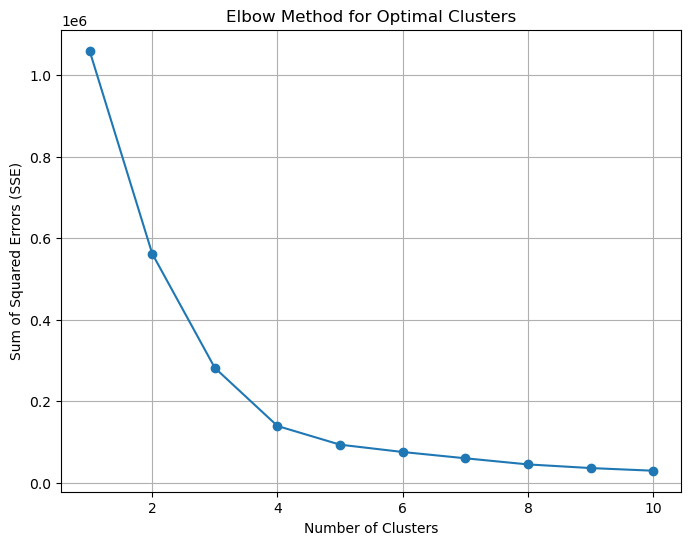

In [42]:
# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal Clusters')
plt.grid(True)
plt.show()

In [43]:
# Based on the plot, choose the optimal number of clusters 
optimal_num_clusters = 4

In [44]:
# Apply K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
kmeans.fit(X_scaled)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [45]:
df.loc[X.index, 'Cluster'] = kmeans.labels_

In [46]:
# Display the first five rows with cluster labels
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country        Date  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  2010-12-01   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  2010-12-01   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  2010-12-01   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  2010-12-01   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  2010-12-01   

   TotalSum  Cluster  
0     15.30      0.0  
1     20.34      0.0  
2     22.00      0.0  
3     20.34      0